<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-6/storing-data-as-tfrecord.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-6/storing-data-as-tfrecord.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 6 - What’s in thMaximizing Speed and Performance of TensorFlow: A Handy Checklist](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch06.html).

In [1]:
try:
    # Mount Google Drive
    from google.colab import drive

    drive.mount("/content/gdrive")

    IS_COLAB_ENV = True
except:
    IS_COLAB_ENV = False
IS_COLAB_ENV

Mounted at /content/gdrive


True

# Data Preparation

Image datasets typically consist of thousands of tiny files, each file measuring a few kilobytes. And our training pipeline must read each file individually. Doing this thousands of times has significant overhead, causing a slowdown of the training process. That problem is even more severe in the case of spinning hard drives, for which the magnetic head needs to seek to the beginning of each file. This problem is further exacerbated when the files are stored on a remote storage service like the cloud.

## Storing data as TFRecords

One solution is to store the data using TFRecord. It combines thousands of files into a handful of larger files. and stores data in an efficient Protocol Buffer (protobuf) objects, making them quicker to read. Let’s see how to create TFRecord files in TensorFlow 2.0:

Note: If you are using an older version of TensorFlow you will need to enable `eager execution` by uncommenting `tf.enable_eager_execution()` and restarting the kernel.

In [2]:
import tensorflow as tf

from PIL import Image
import numpy as np
import io
import IPython.display as display

# If you are using Jupyter notebook on a version prior to TensorFlow 2.0, uncomment the following line and restart the Kernel.
# tf.enable_eager_execution()

Let's download an example image:

In [3]:
def download_sample_image(filename):
    import requests

    url = f"https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/{filename}"
    open(filename, "wb").write(requests.get(url).content)

In [4]:
IMG_PATH = "../../sample-images/cat.jpg"
if IS_COLAB_ENV:
    IMG_PATH = "cat.jpg"
    download_sample_image(IMG_PATH)

Let's see what the image looks like.

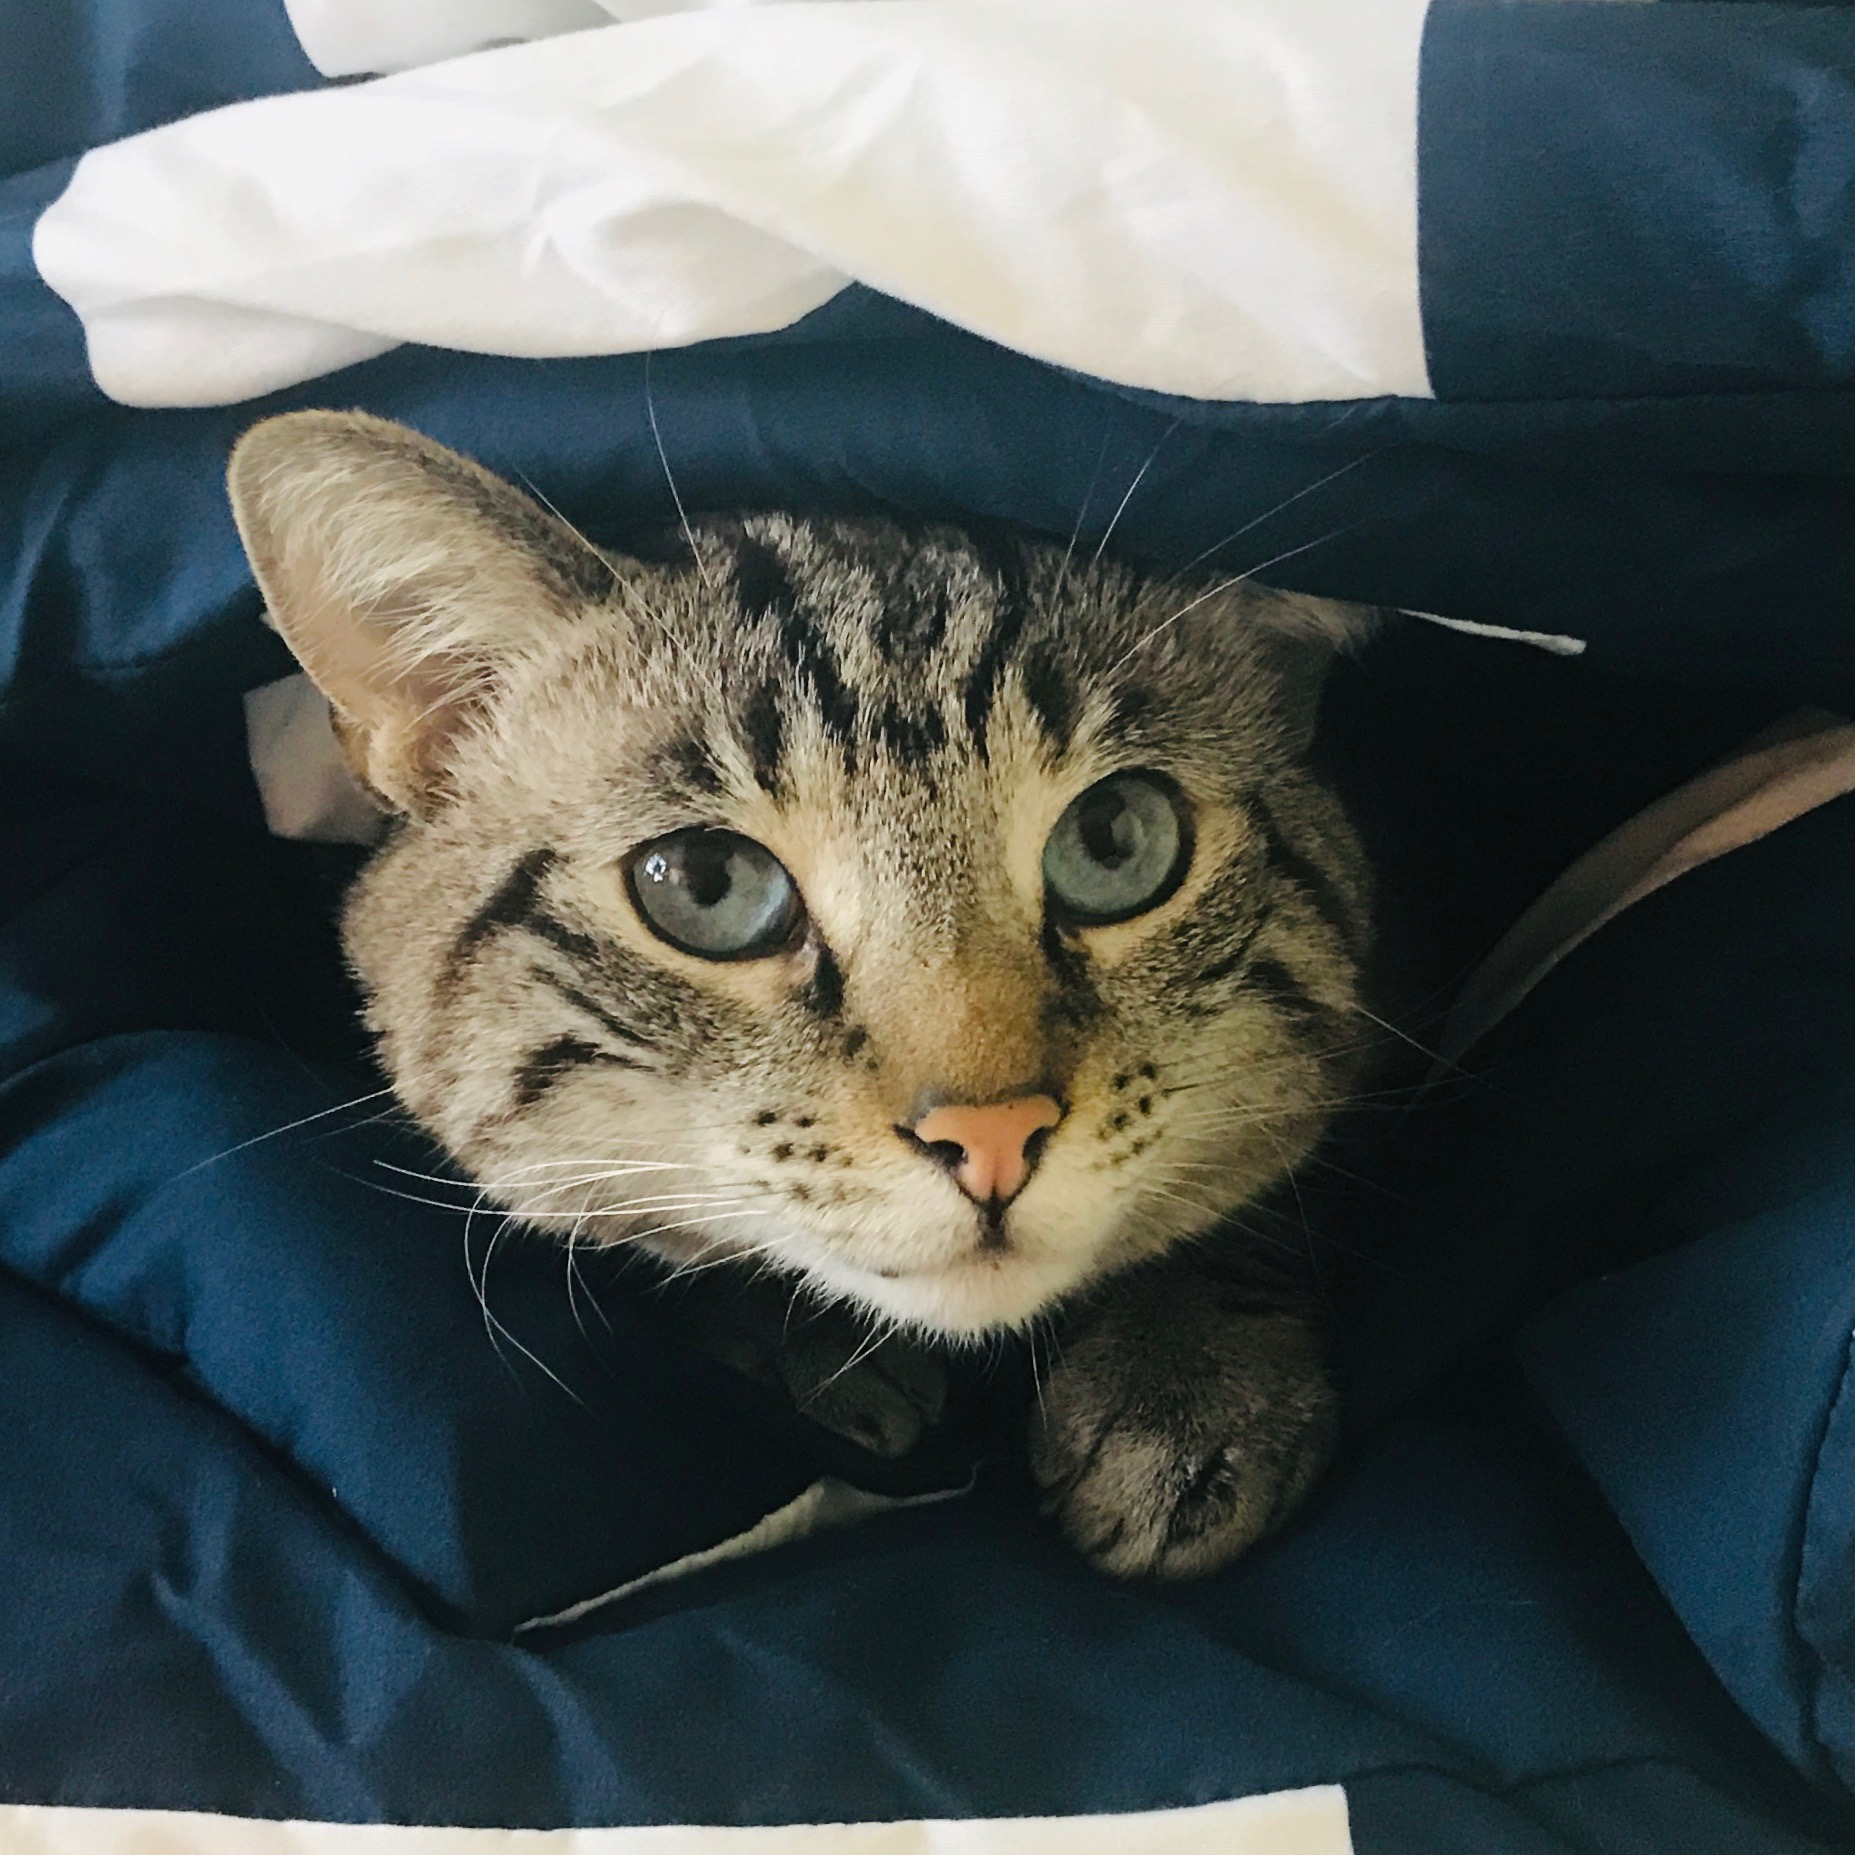

In [5]:
display.display(display.Image(data=IMG_PATH))

Now, to convert the image into `TFRecord` format:

In [6]:
img_name_to_labels = {IMG_PATH: 0}
img_in_string = open(IMG_PATH, "rb").read()
label_for_img = img_name_to_labels[IMG_PATH]

In [7]:
print(img_name_to_labels)

{'cat.jpg': 0}


In [8]:
# Credit: Vishwanath Subramanian: https://github.com/PracticalDL/Practical-Deep-Learning-Book/issues/95


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [9]:
def get_tfrecord(img, label):
    feature = {
        "label": _int64_feature(label),
        "image_raw": _bytes_feature(img),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

Write the serialized `TFRecord` file to disk:

In [10]:
tfrecord_path = "img.tfrecord"
if IS_COLAB_ENV:
    ! mkdir "/content/gdrive/MyDrive/Practical-Deep-Learning-Book/code-outputs/chapter-6/"
    tfrecord_path = f"/content/gdrive/MyDrive/Practical-Deep-Learning-Book/code-outputs/chapter-6/{tfrecord_path}"

with tf.compat.v1.python_io.TFRecordWriter(tfrecord_path) as writer:
    for filename, label in img_name_to_labels.items():
        print(filename)
        image_string = open(filename, "rb").read()
        tf_example = get_tfrecord(image_string, label)
        writer.write(tf_example.SerializeToString())

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Practical-Deep-Learning-Book/code-outputs/chapter-6/’: File exists
cat.jpg


Reading the `TFRecord` file:

In [11]:
dataset = tf.data.TFRecordDataset(tfrecord_path)
ground_truth_info = {
    "label": tf.compat.v1.FixedLenFeature([], tf.int64),
    "image_raw": tf.compat.v1.FixedLenFeature([], tf.string),
}

In [12]:
def map_operation(read_data):
    return tf.compat.v1.parse_single_example(read_data, ground_truth_info)

In [13]:
images = dataset.map(map_operation)

Display the read file:

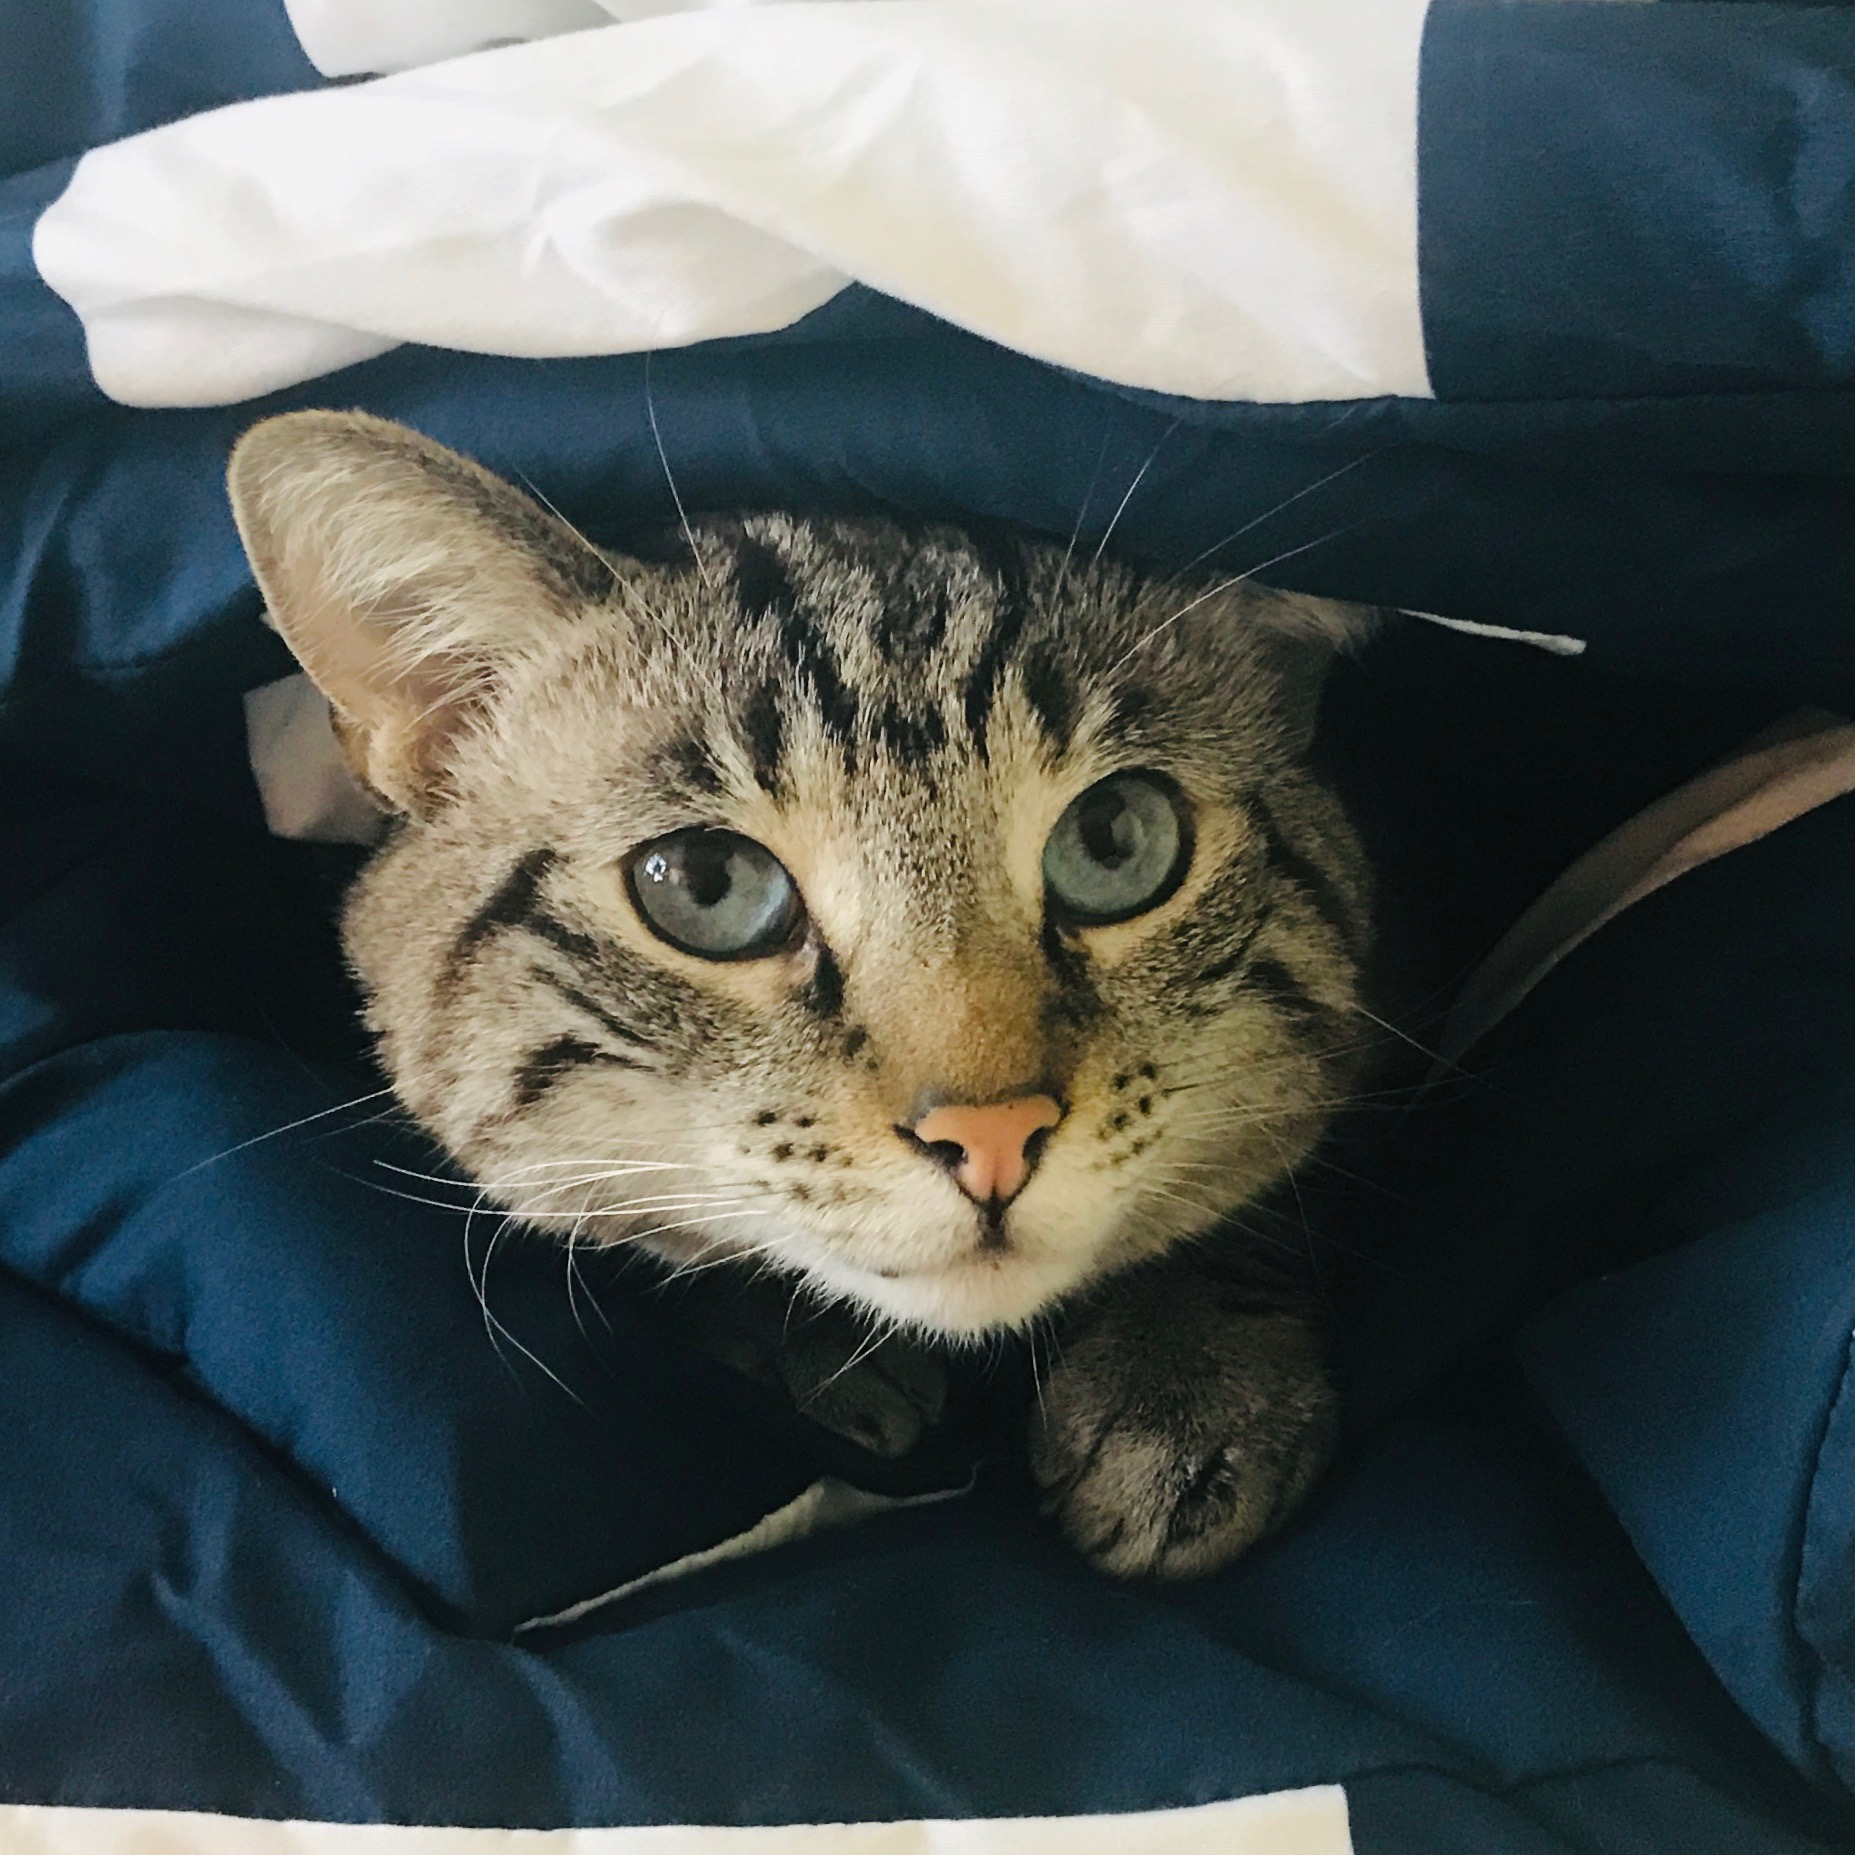

In [14]:
for image in images:
    image_raw = image["image_raw"].numpy()
    label = image["label"].numpy()
    display.display(display.Image(data=image_raw))

Now you may be thinking, why not join all of the data in a single file, like say for ImageNet?

- Although reading thousands of tiny files harms performance due to the overhead involved, reading gigantic files is an equally bad idea. They reduce our ability to make parallel reads and parallel network calls.
- The sweet spot to shard (divide) a large dataset in `TFRecord` files lies at around 100 MB.

Another good strategy to save compute cycles is to perform common preprocessing steps once on the entire dataset (like resizing) and then saving the results in `TFRecord` files for all future runs.

[Read on](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch06.html) for more strategies.
